# Finding the Optimal Amount of Lagged Variables for XGBoost

The goal of this notebook is to find the ideal amount of lagged variables for forecast a given time series with XGBoost.

In [124]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.stats.stattools import durbin_watson
from sklearn.cluster import KMeans

plt.style.use('fivethirtyeight')

In [2]:
pjme = pd.read_csv('data/PJME_hourly.csv', index_col=[0], parse_dates=[0])

### Train/Test Split

In [3]:
split_date = '01-JAN-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

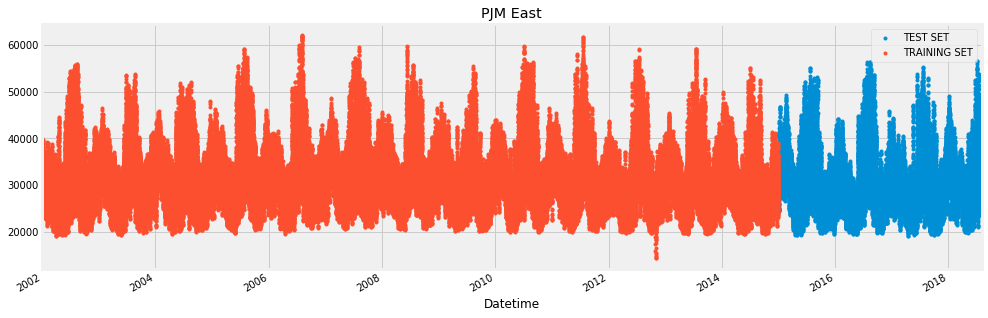

In [4]:
temp_plot = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

### Core Functions

In [5]:
def create_lagged_features(df, lag_count):
    """Creates N lagged features (N = lag_count)"""
    # lag_count should be the number of lags to create
    
    for i in range(0, lag_count):
        df['t-{}'.format(i+1)] = df['PJME_MW'].shift(i+1)

    return df

In [6]:
def create_features(df, lag_count, label=None):
    """Creates additional time series columns from a datetime index"""
    # Date Features
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    # Lagged Features
    
    df = create_lagged_features(df, lag_count)
    
    column_set = ['hour','dayofweek','quarter','month','year',
                   'dayofyear','dayofmonth','weekofyear']
    
    for i in range(0, lag_count):
        column_set.append('t-{}'.format(i+1))
    
    X = df[column_set]
    
    if label:
        y = df[label]
        # Drop first 10 (not enough lagged variables)
        X = X[lag_count:]
        y = y[lag_count:]
        return X, y
    
    # Drop first 10 (not enough lagged variables)
    X = X[lag_count:]
    
    return X

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
def create_xgboost_model(X_train, y_train, X_test, y_test):
    """Creates the XGBoost Model and prints runtime"""
    start = datetime.datetime.now()
    reg = xgb.XGBRegressor(n_estimators=1000)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=50,
           verbose=False) # Change verbose to True if you want to see it train
    end = datetime.datetime.now()
    print("Total runtime for XGBoost: ", end-start)
    
    return reg

In [23]:
def create_rmse_curve(max_lag_count):
    """Builds successive XGBoost models with increasing amounts of lag count"""
    """Returns RMSE, MAPE, and DW curves"""
    mape_list = [] # Mean Absolute Percentage Error
    rmse_list = [] # Root Mean Squared Error
    dw_list = [] # Durbin Watson
    
    for lag_count in range(0, max_lag_count):
        
        X_train, y_train = create_features(pjme_train, lag_count, label='PJME_MW')
        X_test, y_test = create_features(pjme_test, lag_count, label='PJME_MW')
        
        reg = create_xgboost_model(X_train, y_train, X_test, y_test)
        
        temp_pjme_test = pjme_test[lag_count:]
        temp_pjme_test['MW_Prediction'] = reg.predict(X_test)
        
        temp_pjme_test['error'] = temp_pjme_test['MW_Prediction'] - temp_pjme_test['PJME_MW']
        temp_dw = durbin_watson(temp_pjme_test['error'])
        temp_mape = round(mean_absolute_percentage_error(temp_pjme_test['PJME_MW'], temp_pjme_test['MW_Prediction']), 4)
        temp_rmse = math.sqrt(mean_squared_error(y_true=temp_pjme_test['PJME_MW'], y_pred=temp_pjme_test['MW_Prediction']))
        
        print("Lag Count: ", lag_count) 
        print("DW: ", temp_dw) 
        print("MAPE: ", temp_mape) 
        print("RMSE: ", temp_rmse) 
        
        mape_list.append(temp_mape)
        rmse_list.append(temp_rmse)
        dw_list.append(temp_dw)
        
    return mape_list, rmse_list, dw_list
    

In [45]:
mape_curve, rmse_curve, dw_curve = create_rmse_curve(20)

C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[09:54:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:13.009204
Lag Count:  0
DW:  0.06270057505590743
MAPE:  8.9494
RMSE:  3712.202251643081


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Us

[09:54:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:38.455116


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Us

Lag Count:  1
DW:  1.4234141229594426
MAPE:  1.4267
RMSE:  749.462701955032
[09:55:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:01:16.346302


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Us

Lag Count:  2
DW:  1.7310954181481235
MAPE:  1.2352
RMSE:  693.5647535572264
[09:56:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:01:23.345096


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Us

Lag Count:  3
DW:  1.7187207129893796
MAPE:  1.2282
RMSE:  689.5532446978996
[09:58:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:01:37.433402


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Us

Lag Count:  4
DW:  1.6811244439818807
MAPE:  1.2444
RMSE:  694.7980360005433
[09:59:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:01:43.406792


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Lag Count:  5
DW:  1.7002188378182512
MAPE:  1.2434
RMSE:  694.0615170553124


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:01:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:01:56.577030


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Lag Count:  6
DW:  1.7044945587596174
MAPE:  1.231
RMSE:  687.3574966299955


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:03:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:02:06.273983


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Us

Lag Count:  7
DW:  1.7174093643208426
MAPE:  1.2384
RMSE:  689.4710306712391
[10:05:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:02:12.363235


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Lag Count:  8
DW:  1.7117196798330843
MAPE:  1.2293
RMSE:  685.7860041168989


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:07:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:02:23.562189


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Us

Lag Count:  9
DW:  1.7122966107308093
MAPE:  1.2478
RMSE:  690.0049762934755
[10:10:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:02:28.136875


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Us

Lag Count:  10
DW:  1.7244559355013758
MAPE:  1.2452
RMSE:  689.8694442797807
[10:12:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:02:33.401930


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Us

Lag Count:  11
DW:  1.7184982227647856
MAPE:  1.2591
RMSE:  695.3225929017973
[10:15:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:02:47.364554


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Lag Count:  12
DW:  1.7081992825863839
MAPE:  1.2687
RMSE:  694.3308273980159


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:18:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:02:28.220076


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Lag Count:  13
DW:  1.7066365745714709
MAPE:  1.2786
RMSE:  695.8410185164923


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:20:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:02:58.678490


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Lag Count:  14
DW:  1.7043129776203727
MAPE:  1.2428
RMSE:  682.1916803839763


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:23:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:02:58.999815


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Lag Count:  15
DW:  1.7290038200727225
MAPE:  1.2493
RMSE:  679.8605109894819


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:26:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:03:06.520906


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Lag Count:  16
DW:  1.7260817282258
MAPE:  1.2484
RMSE:  677.3774737490345


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:29:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:03:17.381867


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Lag Count:  17
DW:  1.7110891960798866
MAPE:  1.2546
RMSE:  683.4175668326989


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:32:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:06:56.057200


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Lag Count:  18
DW:  1.7494907606015377
MAPE:  1.2511
RMSE:  678.1357061819857


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:39:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:03:32.597321
Lag Count:  19
DW:  1.7205040415106043
MAPE:  1.2675
RMSE:  669.1944569573085


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Plot RMSE, DW, and MAPE

In [52]:
curves = pd.DataFrame({'rmse': rmse_curve, 'dw': dw_curve, 'mape': mape_curve})

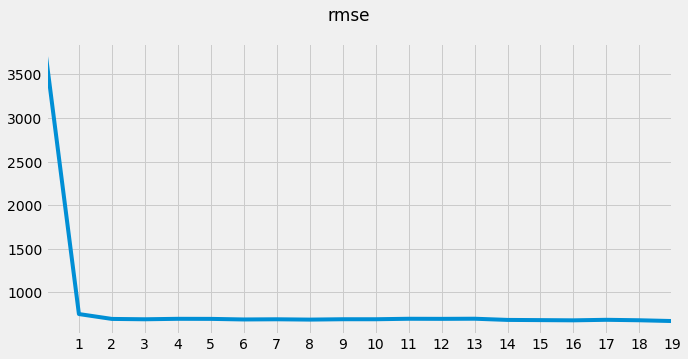

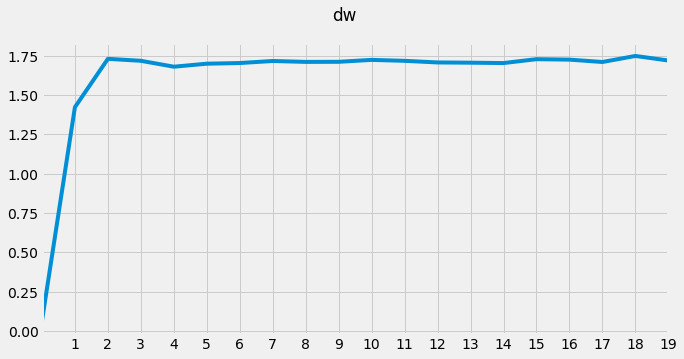

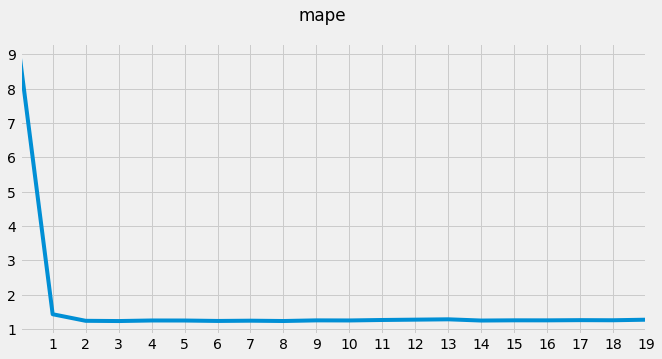

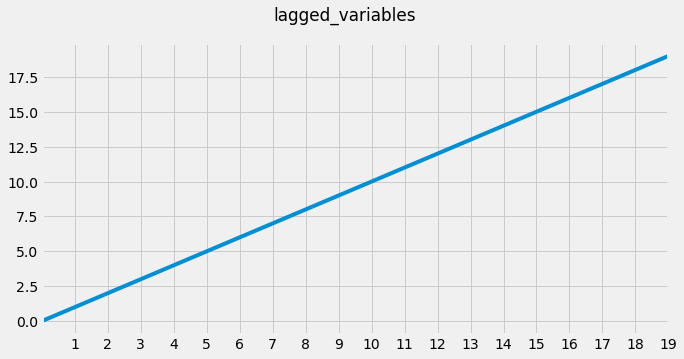

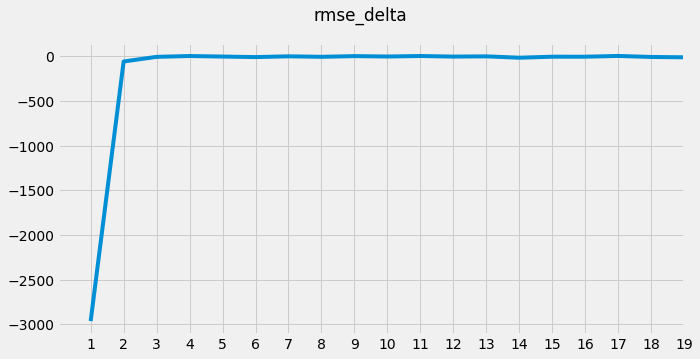

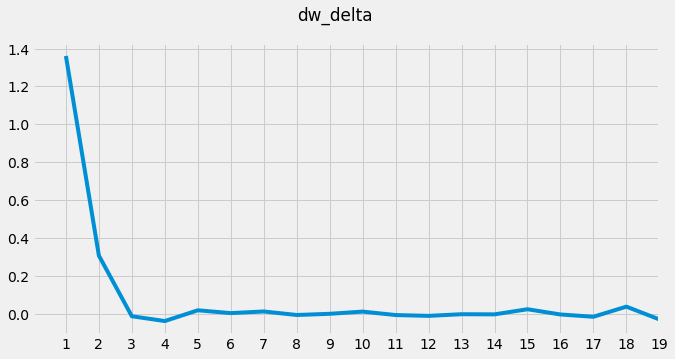

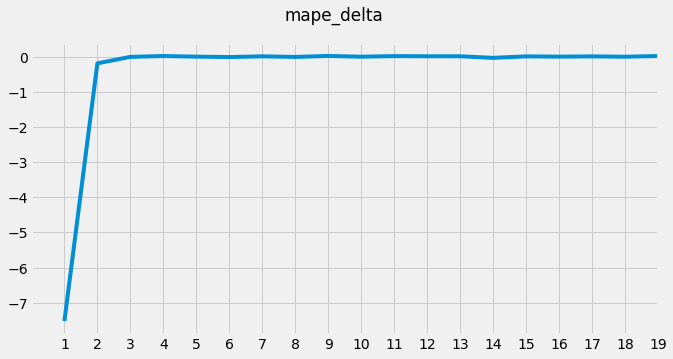

In [114]:
for curve in curves.columns:
    f, ax = plt.subplots(1)
    tick_location = np.linspace(1, 20, num=20, endpoint=True) # set tick locations
    ax.set_xticks(tick_location) # set ticks
    f.set_figheight(5)
    f.set_figwidth(10)
    temp_plot = curves[curve].plot(ax=ax,style=['-'])
    plot = plt.suptitle(curve)

#### A closer look at RMSE:

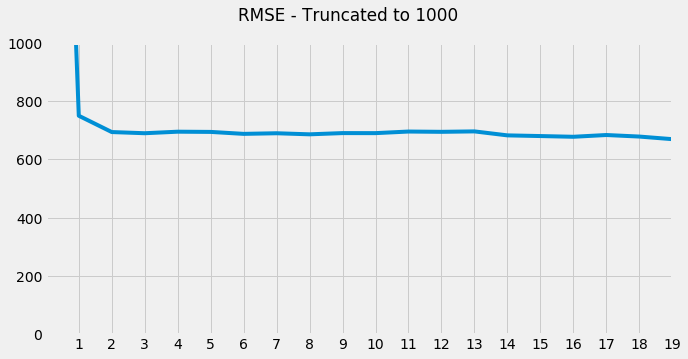

In [115]:
f, ax = plt.subplots(1)
# Set up ticks
tick_location = np.linspace(1, 20, num=20, endpoint=True)
ax.set_xticks(tick_location)
f.set_figheight(5)
f.set_figwidth(10)
temp_plot = curves['rmse'].plot(ax=ax,style=['-'])
ax.set_ylim(0, 1000)
plot = plt.suptitle('RMSE - Truncated to 1000')

### Create deltas for RMSE, DW, and MAPE curves

In [85]:
curves['lagged_variables'] = curves.index
curves['rmse_delta'] = curves['rmse'] - curves['rmse'].shift(1)
curves['dw_delta'] = curves['dw'] - curves['dw'].shift(1)
curves['mape_delta'] = curves['mape'] - curves['mape'].shift(1)
curves

,rmse,dw,mape,lagged_variables,rmse_delta,dw_delta,mape_delta
0,3712.202252,0.062701,8.9494,0,NaN,NaN,NaN
1,749.462702,1.423414,1.4267,1,-2962.739550,1.360714,-7.5227
2,693.564754,1.731095,1.2352,2,-55.897948,0.307681,-0.1915
3,689.553245,1.718721,1.2282,3,-4.011509,-0.012375,-0.0070
4,694.798036,1.681124,1.2444,4,5.244791,-0.037596,0.0162
5,694.061517,1.700219,1.2434,5,-0.736519,0.019094,-0.0010
6,687.357497,1.704495,1.2310,6,-6.704020,0.004276,-0.0124
7,689.471031,1.717409,1.2384,7,2.113534,0.012915,0.0074
8,685.786004,1.711720,1.2293,8,-3.685027,-0.005690,-0.0091
9,690.004976,1.712297,1.2478,9,4.218972,0.000577,0.0185


### Finding Optimal Lagged Variables

In [312]:
def find_optimal_lagged_variables(curves, metric):
    curves = create_groups(curves, metric)
    num_lags = get_num_lags(curves, metric)['lagged_variables'][0]
    return num_lags

In [313]:
def create_groups(curves, metric):
    temp_kmeans = KMeans(n_clusters=2, random_state=0).fit(curves[[metric, 'lagged_variables']])
    curves['{}_group'.format(metric)] = temp_kmeans.labels_
        
    return curves

In [314]:
def get_num_lags(curve, metric):
    """Get optimal number of lags"""
    group_means = {}
    for group in set(curve['{}_group'.format(metric)]):
        relevent_group = curve[curve['{}_group'.format(metric)] == group]
        group_means.update({group: relevent_group[metric].mean()})
        
    # Choose the group with a lower mean RMSE
    if group_means[0] <= group_means[1]:
        selected_group = 0
    else:
        selected_group = 1
        
    # Create a temporary curve containing only members of the selected group
    temp_curve = curve[curve['{}_group'.format(metric)] == selected_group].reset_index(drop=True)
          
    # Get number of lags
    if selected_group == curve['{}_group'.format(metric)][0]:
        # If selected_group is ordinally first, choose the last observation
        num_lags = temp_curve.tail(1)
    else:
        # If selected_group is ordinally last, choose the first observation
        num_lags = temp_curve.head(1)
    
    return num_lags

In [316]:
lagged_curves = curves[1:].reset_index(drop=True)
optimal_lags = find_optimal_lagged_variables(lagged_curves, 'rmse')
optimal_lags

2

### Conclusion

By using k-mean to detect a mean-shift, we can identify the optimal number of lags to use.

The optimal number of lagged variables to include is 2, as any number of lags beyond that are faced with diminishing returns.

### Future considerations for identifying optimal amount of lagged variables:

* LASSO Regression for Feature Selection
    * It may be possible to use LASSO Regression to relevent select variables on its own.
    * By dumping a large number of lags into the regression, it may possible to identify non-sequential lags with predictive power. (ie: t-1, t-2, t-12, t-24)
    * https://stats.stackexchange.com/questions/226468/how-many-lags-should-i-include-in-time-series-prediction
    
* Recursive Feature Selection (RFE)
    * See LASSO.
    * https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/
    
* Traditional Criteria:
    * AIC: Akaike Information Criterion
    * BIC: Schwartcz Information Criterion
    * http://www.fucape.br/_public/producao_cientifica/2/Carrasco%20-%20Selection%20of%20optimal.pdf
        * "Lutkepohl (1993) indicated thatselecting a higher order lag length than the true one causes an increase in themean square forecast error"
		* "Underfitting the lag length often generates autocorrelated error"
		*  "Braun and Mittnik (1993) showed that impulse response functions and variance decompositions are inconsistently derived from the estimated VAR when the lag length differs from the true length."

    * Concerns about traditional criteria: 
        * Hendry and Juselius (2001) in the context of Johansen cointegration. They suggest that the lag length ought to be set such that the VAR residuals are free of autocorrelation, even if this implies longer lags than suggested by the information criteria.